<a href="https://colab.research.google.com/github/ashyrion/ML/blob/master/recommand_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('/content/gdrive/My Drive/data/tmdb_5000_credits.csv')
df2 = pd.read_csv('/content/gdrive/My Drive/data/tmdb_5000_movies.csv')

**Demographic Filtering**

영화 인기 및 / 또는 장르에 따라 모든 사용자에게 일반화 된 권장 사항을 제공합니다. 시스템은 유사한 인구 통계 기능을 가진 사용자에게 동일한 영화를 권장합니다. 각 사용자가 다르기 때문에이 방법은 너무 간단한 것으로 간주됩니다. 이 시스템의 기본 개념은보다 대중적이고 비평적인 영화는 일반 대중이 좋아할 가능성이 더 높다는 것입니다.

**Content Based Filtering**

특정 항목을 기준으로 유사한 항목을 제안합니다. 이 시스템은 영화에 장르, 감독, 설명, 배우 등의 항목 메타 데이터를 사용하여 이러한 권장 사항을 만듭니다. 이러한 추천 시스템의 기본 개념은 특정 품목을 좋아하는 사람과 유사한 품목을 좋아한다는 것입니다.

**Collaborative Filtering**

이 시스템은 비슷한 관심사를 가진 사람들과 일치하며이 일치를 기반으로 권장 사항을 제공합니다. 협업 필터에는 컨텐츠 기반의 항목과 같은 항목 메타 데이터가 필요하지 않습니다.

In [5]:
df1.columns = ['id','title','cast', 'crew']
df2 = df2.merge(df1, on = 'id')


In [6]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Demographic Filtering -
Before getting started with this -


- 영화를 평가하거나 평가하려면 통계가 필요합니다
- 모든 영화에 대한 점수를 계산
- 점수를 정렬하고 사용자에게 최고 등급의 영화를 추천하십시오.

우리는 영화의 평균 등급을 점수로 사용할 수 있지만 평균 8.9 등급의 영화와 7.8의 평균 등급은 40 표인 영화보다 3 표만 더 나은 것으로 간주 될 수 없으므로 충분하지 않습니다. 따라서 IMDB의 가중 등급 (wr)을 다음과 같이 사용합니다.

![대체 텍스트](https://image.ibb.co/jYWZp9/wr.png)

where,

- v는 영화에 대한 투표 수입니다.
- m은 차트에 표시되어야하는 최소 투표 수입니다.
- R은 영화의 평균 등급입니다. 과
- C는 전체 보고서의 평균 투표입니다.


In [7]:
c = df2['vote_average'].mean()
c

6.092171559442011

In [8]:
m = df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [9]:
q_movie = df2.copy().loc[df2['vote_count'] >= m]
q_movie.shape

(481, 23)

In [10]:
def weighted_rating(x, m=m, c=c):
  v = x['vote_count']
  R = x['vote_average']
  return (v/(v+m) * R)+ (m/(m+v) * c)

In [11]:
q_movie['score'] = q_movie.apply(weighted_rating, axis=1)

In [12]:
q_movies = q_movie.sort_values('score', ascending=False)

q_movies[['original_title', 'vote_count', 'vote_average', 'score']].head(10)

,original_title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

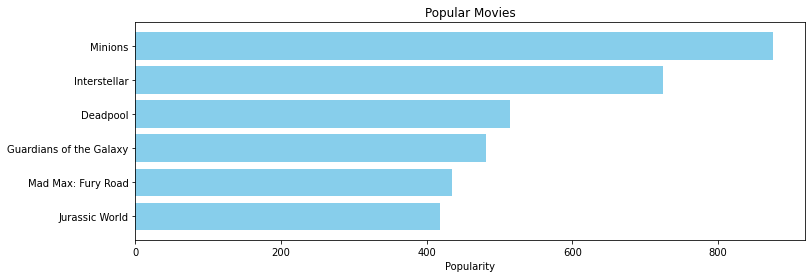

In [13]:
pop = df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))

plt.barh(pop['original_title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

**Content Based Filtering**

이 추천 시스템에서 영화의 내용 (개요, 캐스트, 제작진, 키워드, 태그 라인 등)은 다른 영화와의 유사성을 찾기 위해 사용됩니다. 그런 다음 가장 유사한 영화가 권장됩니다.

In [14]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object


이전에 약간의 텍스트 처리를 한 사람이라면 각 개요의 단어 벡터를 변환해야한다는 것을 알고 있습니다. 이제 각 개요에 대해 TF-IDF (Term Frequency-Inverse Document Frequency) 벡터를 계산합니다.

이제 frequency 용어가 무엇인지 궁금하다면 문서에서 단어의 상대적 빈도이며 (term instance / total instance)로 제공됩니다. 역 문서 빈도는 용어를 포함하는 문서의 상대적 개수입니다 (로그가있는 문서 / 문서 수). 단어가 나타나는 문서에 대한 각 단어의 전체 중요도는 TF * IDF와 같습니다.

이렇게하면 각 열이 개요 어휘 (한 개 이상의 문서에 나타나는 모든 단어)의 단어를 나타내며 각 행은 이전과 같이 영화를 나타냅니다. 이는 자주 발생하는 단어의 중요성을 줄이기 위해 수행됩니다. 플롯 개요에서 최종 유사성 점수를 계산할 때의 중요성.

다행히도 scikit-learn은 몇 줄로 TF-IDF 매트릭스를 생성하는 내장 TfIdfVectorizer 클래스를 제공합니다.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

df2['overview'] = df2['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(df2['overview'])

tfidf_matrix.shape

(4803, 20978)

우리는 데이터 세트에서 4800 개의 영화를 설명하기 위해 20,000 개 이상의 다른 단어가 사용되었음을 알 수 있습니다.

이 행렬을 사용하면 유사성 점수를 계산할 수 있습니다. 이에 대한 몇 가지 후보가 있습니다. 유클리드, 피어슨 및 코사인 유사성 점수와 같은 어떤 점수가 최고인지에 대한 정답은 없습니다. 다른 점수는 다른 시나리오에서 잘 작동하며 다른 메트릭을 실험 해 보는 것이 좋습니다.

우리는 코사인 유사성을 사용하여 두 영화 사이의 유사성을 나타내는 숫자 수량을 계산할 것입니다. 코사인 유사성 점수는 크기와 무관하며 계산하기가 비교적 쉽고 빠르기 때문에 코사인 유사성 점수를 사용합니다. 수학적으로 다음과 같이 정의됩니다.

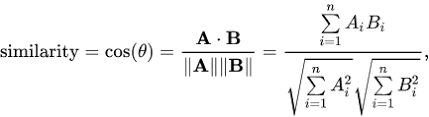


TF-IDF 벡터 라이저를 사용 했으므로 내적 계산은 코사인 유사성 점수를 직접 제공합니다. 따라서 cosine_similarities () 대신 sklearn의 linear_kernel ()을 사용합니다. 속도가 빠르기 때문입니다.

In [16]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


영화 제목을 입력으로 받아 가장 유사한 10 개의 영화 목록을 출력하는 함수를 정의하려고합니다. 먼저 영화 타이틀과 DataFrame 인덱스의 역 매핑이 필요합니다. 다시 말해, 타이틀에 따라 메타 데이터 DataFrame에서 동영상의 인덱스를 식별하는 메커니즘이 필요합니다.

In [17]:
indices = pd.Series(df2.index, index=df2['original_title']).drop_duplicates()
indices.head(5)

original_title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

우리는 이제 추천 기능을 정의 할 수있는 좋은 위치에 있습니다. 다음 단계는 다음과 같습니다.

- 제목이 주어진 영화의 색인을 가져옵니다.
- 모든 영화가있는 특정 영화의 코사인 유사성 점수 목록을 가져옵니다. 첫 번째 요소가 위치이고 두 번째 요소가 유사성 점수 인 튜플 목록으로 변환하십시오.
- 유사성 점수를 기준으로 위에서 언급 한 튜플 목록을 정렬합니다. 즉, 두 번째 요소입니다.
- 이 목록의 상위 10 개 요소를 가져옵니다. 자기 자신을 가리키는 첫 번째 요소는 무시하십시오 (특정 영화와 가장 유사한 영화는 영화 자체 임).
- 상단 요소의 색인에 해당하는 제목을 반환합니다.

In [18]:
def get_recommendations(title, cosine_sim=cosine_sim):
  idx = indices[title]

  sim_scores = list(enumerate(cosine_sim[idx]))

  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  sim_scores = sim_scores[1:11]

  movie_indices = [i[0] for i in sim_scores]

  return df2['original_title'].iloc[movie_indices]

In [19]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: original_title, dtype: object

In [20]:
get_recommendations('Wall Street')

2622                       The In Crowd
298             The Wolf of Wall Street
588     Wall Street: Money Never Sleeps
1486                       The Punisher
3341                         Magic Mike
2233                         Little Boy
751                           Duplicity
1195                            Unknown
2864                          Arbitrage
3963                 They Came Together
Name: original_title, dtype: object

**Credits, Genres and Keywords Based Recommender**

더 나은 메타 데이터를 사용하면 추천자의 품질이 향상 될 것입니다. 이것이 바로이 섹션에서 우리가 할 일입니다. 우리는 3 가지 최고의 배우, 감독, 관련 장르 및 영화 플롯 키워드와 같은 메타 데이터를 기반으로 추천자를 구성 할 것입니다.

출연진, 제작진 및 키워드 기능에서 가장 중요한 세 배우, 감독 및 해당 영화와 관련된 키워드를 추출해야합니다. 지금 우리의 데이터는 "stringified"리스트 형태로 존재합니다. 안전하고 사용 가능한 구조로 변환해야합니다.

In [21]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
  df2[feature] = df2[feature].apply(literal_eval)

In [22]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [23]:
def get_list(x):
  if isinstance(x, list):
    names = [i['name'] for i in x]

    if len(names) > 3:
      names = names[:3]
    return names
  return []

In [24]:
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [25]:
df2[['original_title', 'cast', 'director', 'keywords', 'genres']].head(3)

,original_title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [26]:
def clean_data(x):
  if isinstance(x, list):
    return [str.lower(i.replace(" ","")) for i in x]
  else:
    if isinstance(x, str):
      return str.lower(x.replace(" ", ""))
    else:
      return ''

In [27]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
  df2[feature] = df2[feature].apply(clean_data)


이제 "메타 데이터 수프"를 만들 수 있습니다.이 메타 데이터는 벡터 라이저에 제공 할 모든 메타 데이터 (배우, 감독 및 키워드)가 포함 된 문자열입니다.

In [28]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)


다음 단계는 플롯 설명 기반 추천자로 수행 한 것과 동일합니다. 중요한 차이점 중 하나는 TF-IDF 대신 CountVectorizer ()를 사용한다는 것입니다. 이는 배우 / 감독이 상대적으로 더 많은 영화에서 행동하거나 감독 한 경우 그 존재를 줄이려고하지 않기 때문입니다. 그다지 직관적이지 않습니다.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])
count_matrix

<4803x11520 sparse matrix of type '<class 'numpy.int64'>'
	with 42935 stored elements in Compressed Sparse Row format>

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [31]:
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['original_title'])

In [32]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: original_title, dtype: object

In [33]:
get_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: original_title, dtype: object

In [34]:
!pip install scikit-surprise

In [42]:
from surprise import Reader, Dataset, SVD
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

reader = Reader()
ratings = pd.read_csv('/content/gdrive/My Drive/data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [43]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

<generator object KFold.split at 0x7f53ae7eebf8>

In [37]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8930  0.8994  0.8983  0.9012  0.8936  0.8971  0.0032  
MAE (testset)     0.6879  0.6920  0.6910  0.6933  0.6872  0.6903  0.0023  
Fit time          4.91    4.90    4.95    4.88    4.91    4.91    0.02    
Test time         0.28    0.14    0.14    0.14    0.14    0.17    0.06    


{'fit_time': (4.905580043792725,
  4.900787353515625,
  4.946692228317261,
  4.8783886432647705,
  4.910520076751709),
 'test_mae': array([0.68794548, 0.69195043, 0.69104885, 0.69328302, 0.68721984]),
 'test_rmse': array([0.89297601, 0.89944837, 0.89827213, 0.90115782, 0.89358378]),
 'test_time': (0.2821786403656006,
  0.14004802703857422,
  0.13839411735534668,
  0.13660335540771484,
  0.13814377784729004)}

In [45]:
benchmark = []
for algorithm in [SVD(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    result = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    tmp = pd.DataFrame.from_dict(result).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.897145,0.693898,0.200265,0.223730
KNNBaseline,0.903906,0.692399,0.280283,3.182015
SVD,0.905163,0.696755,4.068366,0.321061
KNNWithZScore,0.926954,0.705498,0.164511,2.822675
KNNWithMeans,0.927336,0.709843,0.119504,2.587914
CoClustering,0.971954,0.753373,2.019110,0.307678
KNNBasic,0.978051,0.752493,0.102559,2.405909


In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]


ID가 302 인 영화의 경우 예상 예측치는 2.618입니다. 이 추천 시스템의 놀라운 기능 중 하나는 영화가 무엇인지 (또는 무엇이 포함되어 있는지) 상관하지 않는다는 것입니다. 지정된 영화 ID를 기준으로 순전히 작동하며 다른 사용자가 영화를 어떻게 예측했는지에 따라 등급을 예측하려고합니다.

In [ ]:
svd.predict(1, 1170, 3)